# Algotytm przecinania się odcinków na płaszczyźnie

In [117]:

import numpy as np
import pandas as pd
from bitalg.tests.test4 import Test
from bitalg.visualizer.main import Visualizer
import random as rnd
import tkinter as tk
import matplotlib
import matplotlib.pyplot as plt
from sortedcontainers import SortedSet
from enum import Enum
from typing import List 

%matplotlib inline

# Przydatne funkcje 

In [118]:
def draw_example_1():
    # TODO narysowac to uzywając naszego narzędzia do wizualizacji
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))

    vis.add_line_segment(line_segments)
    vis.show()
    
def draw_example_2():
    # TODO narysowac to uzywając naszego narzędzia do wizualizacji
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))
    points = [(4, 2),
              (2.5, 3.5),
              (5.5, 4.5)]

    vis.add_line_segment(line_segments)
    vis.add_point(points, color='red')
    vis.show()


### Wprowadzenie
Celem ćwiczenia jest implementacja i zapoznanie się z algorytmem wyznaczającym wszystkie przecięcia się odcinków na płaszczyźnie

### Przykładowy zbiór odcinków przed wyznaczeniem punktów przecięcia

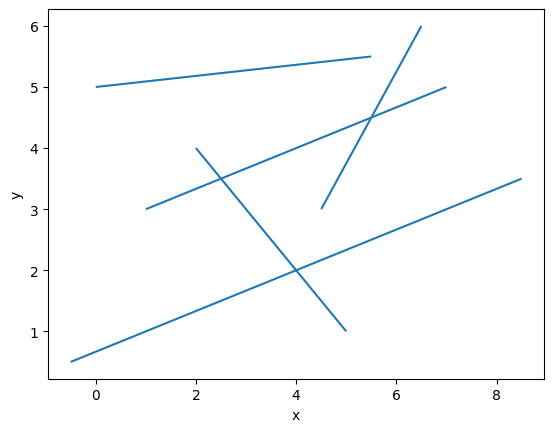

In [119]:
draw_example_1()

### Przykładowy zbiór odcinków po wyznaczenu punktów przecięcia

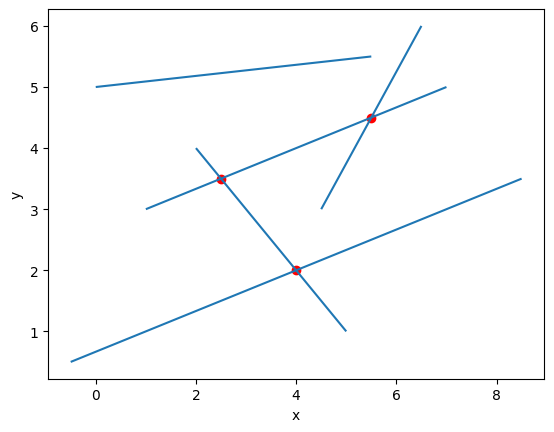

In [120]:
draw_example_2()

In [121]:
EPS = 10**-14

# Generowanie losowych odcinków na płaszczyźnie

Uzupełnij funkcję ```generate_uniform_sections```

In [122]:
def generate_uniform_sections(max_x, max_y, n):
    """
    Funkcja generuje odcinki o współrzędnych rzeczywistych w postaci par punktów. 
    Żaden wygenerowany odcinek nie jest odcinkiem pionowym.
    Żadne dwa odcinki nie mają swoich końców o takiej samej współrzędnej x.
    Zakres współrzędnych: x -> (0, max_x), y -> (0, max_y)
    :param max_x: określa maksymalną wartość współrzednej x jaka może zostać wylosowana
    :param max_y: określa maksymalną wartość współrzednej y jaka może zostać wylosowana
    :param n: ilość generowanych odcinków
    :return: tablica odcinków w postaci krotek zawierających parę krotek współrzędnych punktów końcowych odcinków
    np. [((x1, y1), (x2, y2)), ((x3, y3), (x4, y4)),...]
    """
    segments = []
    xs = set()
    while len(xs) < n:
        xs.add(rnd.uniform(0, max_x))
        
    for x in xs:
        x1 = x
        y1 = rnd.uniform(0, max_y)
        x2 = rnd.uniform(0, max_x)
        y2 = rnd.uniform(0, max_y)

        if x1 ==x2:
            x2 += 0.5

        segments.append(((x1, y1), (x2, y2)))

    return segments

In [123]:
Test().runtest(1, generate_uniform_sections)

Lab 4, task 1:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.125s


<span style="color:red">Ćw.</span> Wygeneruj $\large20$ losowych odcinków w przestrzeni 2D o współrzędnych z przedziału $\large x \in \langle 0,1000 \rangle$ oraz $\large y \in \langle 0,1000\rangle$. 

In [124]:
section = generate_uniform_sections(1000, 1000, 20)

Zwizualizuj otrzymane odcinki

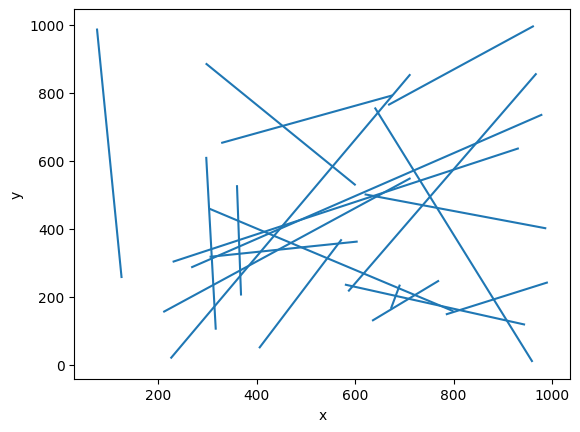

In [125]:
vis = Visualizer()
vis.add_line_segment(section)
vis.show()

Uzupełnij funkcję ```add_sections``` #interaktywne dodawanie odcinków przez rysowanie myszką (jak?) TODO

In [126]:
def add_sections(sections, max_x, max_y):
    matplotlib.use("WebAgg")
    
    fig = plt.figure()
    
    fig.set_label('Polygon Points')
    
    ax = fig.add_subplot(111)
    ax.set_title(f"Please select points for the polygon in counter-clockwise order")
    ax.set_xlim([0, max_x])
    ax.set_ylim([0, max_y])

    cid = None
    points_data = []

    def onclick(event):
        plt.plot(event.xdata, event.ydata, 'bo')
        points_data.append((event.xdata, event.ydata))
        #print((event.xdata, event.ydata))
        if len(points_data) % 2 == 0:
            plt.plot([points_data[-2][0], points_data[-1][0]], [points_data[-2][1], points_data[-1][1]], 'b-')
            sections.append(((points_data[-2][0], points_data[-2][1]), (points_data[-1][0], points_data[-1][1])))
        fig.canvas.draw()

    def on_close(event):
        fig.canvas.mpl_disconnect(cid)
        plt.close(fig)
        %matplotlib inline
        
    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    cid = fig.canvas.mpl_connect('close_event', on_close)
    plt.show()

In [127]:
sections = []
add_sections(sections, 10, 10)

To view figure, visit http://127.0.0.1:8988


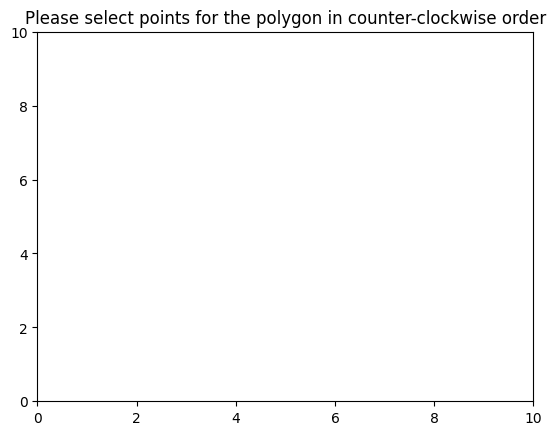

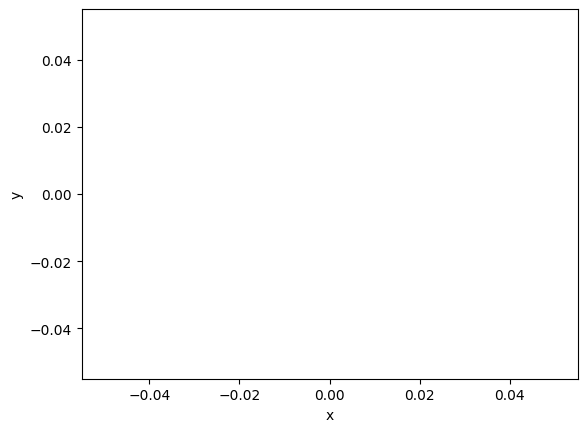

In [128]:
%matplotlib inline
vis = Visualizer()
vis.add_line_segment(sections)
vis.show()

In [129]:
def sgn(x):
    if x > 0:
        return 1
    elif x < 0:
        return -1
    
    return 0

Uzupełnij funkcję ```is_intersection```

In [336]:
class Point():
    def __init__(self, x, y):
        self.x = x
        self.y =y
    
    def getTuple(self):
        return (self.x, self.y)

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    def __hash__(self):
        return hash((self.x, self.y))
    
    def __str__(self):
        return f"({self.x}, {self.y})"
        

class Equation():
    def __init__(self, a, b):
        self.a = a
        self.b = b 

In [131]:
def det(a : Point, b : Point, c : Point):
    '''
    Funkcja zwraca wyznacznik macierzy 2x2 iloczynu wektorowego miedzy wektorami ab bc
    '''
    return (b.x - a.x)*(c.y-b.y) - (b.y-a.y)*(c.x-b.x)

In [337]:
class EventType(Enum):
    START = 0,
    STOP = 1,
    INTERSECT = 2

class Event():
    def __init__(self, type: EventType, event_point : Point, params: any):
        self.type = type
        self.params = params
        self.event_point = event_point

class Section():
    def __init__(self, start : Point, end: Point, id=None):
        if start.x > end.x:
            self.start = end
            self.end = start
        else:
            self.start = start
            self.end = end
        
        self.equation = self.__get_line_equation(start, end)
        self.current_y = start.y
        self.id = id

    def __get_line_equation(self, A : Point, B : Point) -> Equation:
        a = (B.y - A.y)/(B.x - A.x)
        b = A.y - a*A.x

        return Equation(a, b)

    def __str__(self):
        return f"[{self.start} -> {self.end}]"


In [133]:
def check_intersection(section_1 : Section, section_2 : Section):
    A = section_1.start
    B = section_1.end

    C = section_2.start
    D = section_2.end

    d1 = sgn(det(A, B, C))
    d2 = sgn(det(A, B, D))
    d3 = sgn(det(C, D, A))
    d4 = sgn(det(C, D, B))

    # jeden z konców odcinka leży na drugim odcinku
    if d1 == 0 or d2 == 0 or d3 == 0 or d4 == 0:
        return True

    # sprawdzenie czy oba konce jednego odcinka leżą po przeciwnych stronach drugiego
    return d1*d2 < 0 and d3 * d4 < 0

In [365]:
def get_intersection(section_1 : Section, section_2 : Section):
    a_1, b_1 = section_1.equation.a, section_1.equation.b
    a_2, b_2 = section_2.equation.a, section_2.equation.b

    return Point((b_1-b_2)/(a_2 - a_1), (a_2*b_1 - a_1*b_2)/(a_2 - a_1))

In [135]:
def is_intersection(sections):
    """
    Funkcja sprawdza czy jakakolwiek para podanych odcinków się przecina 
    :param sections: tablica odcinków w postaci krotek krotek współrzędnych punktów końcowych odcinków
    :param eps: epsilon będący dokładnością, z jaką porównujemy liczby zmiennoprzecinkowe
    :return: True / False
    """
    sections = [Section(Point(p1[0], p1[1]), Point(p2[0], p2[1])) for p1, p2 in sections]
    
    T = SortedSet(key=lambda section: section.current_y)
    Q = SortedSet(key=lambda point: point[0].x)

    for i, section in enumerate(sections):
        Q.add((section.start, i))
        Q.add((section.end, i))

    while Q:
        p, index = Q.pop(0)

        if p == sections[index].start: # jesli p jest lewym koncem odcinka
            T.add(sections[index])
            i = T.index(sections[index])
        
            if (i - 1 >= 0 and check_intersection(T[i - 1], T[i])) or (i + 1 < len(T) and check_intersection(T[i + 1], T[i])): 
                return True
            
        elif p == sections[index].end: # jęśli p jest prawym końcem odcinka
            T.remove(sections[index])

    return False

In [136]:
Test().runtest(2, is_intersection)

Lab 4, task 2:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.003s


### W jaki sposób zaimplementowałeś struktura stanu (stan miotły) oraz struktura zdarzeń w Twoim programie?

Odpowiedź here

Uzupełnij funkcję ```is_intersection_with_visualization```

In [137]:
def is_intersection_with_visualization(sections): # TODO wizualizacja (jak?)
    """
    Funkcja sprawdza czy jakakolwiek para podanych odcinków się przecina i dodatkowo zwraca kolejne kroki w wizualizacji 
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: True / False
    """
    raise Exception("Unimplemented")

Uzupełnij funkcję ```find_intersections```

In [384]:
def find_intersections(sections):
    """
    Funkcja znajduje wszystkie przecięcia zadanych odcinków
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: tablica punktów przecięć w postaci trzyelementowych krotek w których pierwszym elementem są współrzędne danego punktu, a drugim i trzecim indeksy prostych z listy wejściowej, które się przecinają w tym punkcie współrzędnych np.:
    [((x1, y1), id1,id2),
    ((x2, y2), id3, id4),
    ...]
    """
    vis = Visualizer()
    vis.add_line_segment(sections)
    vis.show()
       
    sections = [Section(Point(p1[0], p1[1]), Point(p2[0], p2[1]), i) for i, (p1, p2) in enumerate(sections)]
    
    T = SortedSet(key=lambda section: section.current_y)
    Q = SortedSet(key=lambda event: event.event_point.x)
    event_points_dict = {}
    
    for i, section in enumerate(sections):
        Q.add(Event(EventType.START, section.start, i))
        Q.add(Event(EventType.STOP, section.end, i))

    intersections = []
    
    while Q:
        event: Event = Q.pop(0)

        if event.type == EventType.START: # jesli p jest lewym koncem odcinka
            T.add(sections[event.params])
            s = T.index(sections[event.params])

            if s - 1 >= 0 and check_intersection(T[s - 1], T[s]): 
                intersection = get_intersection(T[s - 1], T[s])
                if not intersection in event_points_dict:
                    Q.add(Event(EventType.INTERSECT, intersection, (T[s - 1], T[s])))
                    event_points_dict[intersection] = 1

            if s + 1 < len(T) and check_intersection(T[s], T[s + 1]): 
                intersection = get_intersection(T[s], T[s + 1])
                if not intersection in event_points_dict:
                    Q.add(Event(EventType.INTERSECT, intersection, (T[s], T[s + 1])))
                    event_points_dict[intersection] = 1
            
        elif event.type == EventType.STOP: # jęśli p jest prawym końcem odcinka
            s = T.index(sections[event.params])
            if s + 1 < len(T) and s - 1 >= 0 and check_intersection( T[s - 1], T[s + 1]): 
                intersection = get_intersection(T[s - 1], T[s + 1])
                
                if not intersection in event_points_dict:
                    Q.add(Event(EventType.INTERSECT, intersection, (T[s - 1], T[s + 1])))
                    event_points_dict[intersection] = 1
                
            T.pop(s)

        else: # przecięcie:
            s1, s2 = event.params #s2 wyżej niż s1

            intersections.append((event.event_point, s1.id, s2.id))
            del event_points_dict[event.event_point]
            
            i_s1, i_s2 = T.index(s1), T.index(s2)

            T.remove(s1)
            T.remove(s2)

            s1.current_y = s1.equation.a*(event.event_point.x + 0.0001) + s1.equation.b
            s2.current_y = s2.equation.a*(event.event_point.x + 0.0001) + s2.equation.b

            T.add(s1)
            T.add(s2)

            i_s1_new, i_s2_new = T.index(s1), T.index(s2) 

            if i_s1_new + 1 < len(T) and check_intersection(s1, T[i_s1_new + 1]):
                intersection = get_intersection(s1, T[i_s1_new + 1])
                if not intersection in event_points_dict:
                    Q.add(Event(EventType.INTERSECT, intersection, (s1, T[i_s1_new + 1])))
                    event_points_dict[intersection] = 1

            if i_s2_new - 1 >= 0 and check_intersection(T[i_s2_new - 1], s2):
                intersection = get_intersection(T[i_s2_new - 1], s2)
                if not intersection in event_points_dict:
                    Q.add(Event(EventType.INTERSECT, intersection, (T[i_s1 - 1], s2)))
                    event_points_dict[intersection] = 1


    vis.add_point( [(point.x, point.y) for point, _, _ in intersections])
    vis.show()
    intersections = [((point.x, point.y), id1 + 1, id2 + 1) for point, id1, id2 in intersections]
    
    return intersections

Lab 4, task 3:
	Test 1: 

KeyboardInterrupt: 

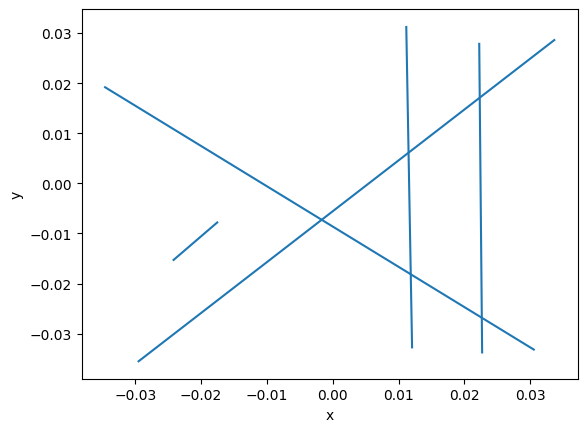

In [385]:
Test().runtest(3, find_intersections)

In [328]:
sect = [((112.90322580645162, 874.4588744588744), (866.9354838709678, 479.43722943722946)), ((88.70967741935485, 568.7229437229438), (913.3064516129032, 833.8744588744589)), ((221.7741935483871, 863.6363636363636), (518.1451612903226, 425.32467532467535)), ((286.2903225806451, 514.6103896103896), (883.0645161290322, 760.8225108225108)), ((669.3548387096774, 831.1688311688312), (816.5322580645162, 668.8311688311688)), ((379.0322580645162, 411.79653679653677), (933.4677419354839, 606.6017316017317)), ((685.483870967742, 400.97402597402595), (872.983870967742, 506.4935064935065)), ((209.6774193548387, 168.2900432900433), (925.4032258064517, 357.68398268398266)), ((112.90322580645162, 457.7922077922078), (856.8548387096774, 38.4199134199134)), ((423.38709677419354, 133.11688311688312), (556.4516129032259, 100.64935064935062))]

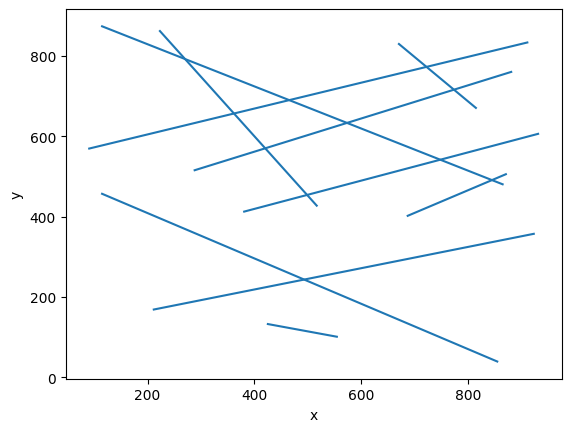

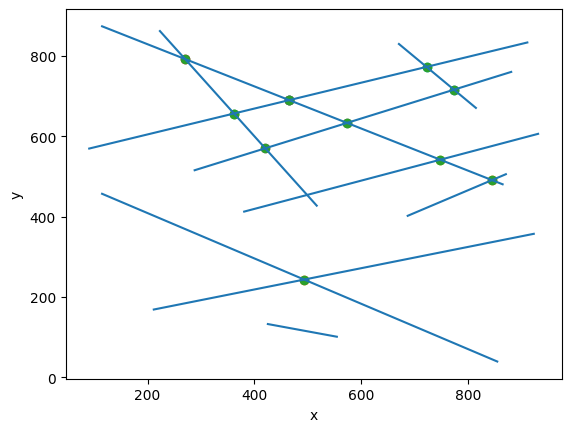

In [379]:
_ = find_intersections(sect)

Uzupełnij funkcję ```find_intersections_with_visualization```

In [ ]:
def find_intersections_with_visualization(sections): # TODO wizualizacja (jak?)
    """
    Funkcja znajduje wszystkie przecięcia zadanych odcinków i dodatkowo zwraca kolejne kroki w wizualizacji 
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: tablica punktów przecięć w postaci trzyelementowych krotek w których pierwszym elementem są współrzędne danego punktu, a drugim i trzecim indeksy prostych z listy wejściowej, które się przecinają w tym punkcie współrzędnych np.:
    [((x1, y1), id1,id2),
    ((x2, y2), id3, id4),
    ...]
    """

### Czy konieczne były zmiany w strukturze zdarzeń. Jeśli tak, to jakie? Czy w przypadku obu algorytmów konieczne są takie same struktury zdarzeń?
### Odpowiedź uzasadnij. 

Odpowiedź here

### Jak obsługiwane są zdarzenia początku odcinka, końca odcinka i przecięcia odcinków z uwzględnianiem wybranych struktur danych?

Odpowiedź here

### Samemu zaprojektuj test, który uwzględnia taki układ odcinków, przy którym pewne przecięcia będą wykrywane więcej niż jeden raz

In [ ]:
# testing_sections = ???

In [ ]:
### Czy Twój program uwzględnia powyższy przypadek? Jeśli tak, to jak? 

Odpowiedź here

### Zadanie dodatkowe
Zaimplementuj inną strukturę stanu. Opisz ją w sprawozdaniu. Porównaj efektywność algorytmu dla obu struktur robiąc testy na odpowiednio dużych zestawach odcinków.